<a href="https://colab.research.google.com/github/we-make-ai/udemy_nlu/blob/main/nlp_ulmfit_german_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchtext==0.8.1
!pip install -U fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [ ]:
!nvidia-smi

# UlmFit Modell für deutsche Sprache erstellen

Wir wollen nun noch ein Sprachmodell für die deutsche Sprache trainieren.

Doch warum erstellen wir noch ein nicht auf der BERT Modellarchitektur aufbauendes Modell?

Die ULMFiT Architektur hat einen großen Vorteil: **Wir können ein ausgesprochen gutes Modell in kurzer Zeit auf "Standardhardware" als Textklassifizierer trainieren.**

Insofern eignet sich ULMFiT sehr gut für eigene (private) Experimente, ohne eine riesige Menge an Daten oder extrem schnelle Hardware.

Verwendete Quellen für dieses Notebook:

*   https://github.com/floleuerer/fastai_ulmfit
*   https://arxiv.org/abs/1801.06146
*   https://github.com/fastai/course-nlp
*   https://arxiv.org/abs/1911.11423

## Download der Daten vom Kurs-Bucket

Wir können sowohl die generierten Sprachmodell-Dateien, wie auch die vollständige Sammlung aller erstellten Dateien - einschließlich der Texte von Wikipedia - vom Kurs-Bucket herunterladen.

In [ ]:
# Alle generierten Dateien herunterladen
!wget https://fastai-german-language-model.s3.eu-de.cloud-object-storage.appdomain.cloud/data.tar.gz
!mkdir data
!%tar -xzf german_language_model.tar.gz

In [ ]:
# Nur die generierten Sprachmodelle herunterladen
# Wenn ich die Sprachmodelle selbst trainieren möchte
!wget https://fastai-german-language-model.s3.eu-de.cloud-object-storage.appdomain.cloud/german_language_model.tar.gz
%mkdir data
%cd data
%mkdir dewiki
%tar -xzf german_language_model.tar.gz
# Nun sind alle erforderlichen Dateien unseres Sprachmodells im Verzeichnis 
# ./data/dewiki/model

## Vorbereitung unserer Trainingsdaten aus deutschen Wikipedia Texten

Während Transformer Modellarchitekturen wie BERT riesige Mengen an Trainingsdaten erfordern, reicht für ein ULMFiT Modell bereits ein relativ kleines Datenset mit 100 Millionen Tokens aus.

Wie auch von fastai vorgeschlagen, wollen wir unser Sprachmodell ebenfalls auf der Basis von Wikipedia-Texten generieren.

Dazu sind folgende Schritte erforderlich:



1.   Herunterladen der Textdaten aus Wikipedia
1.   Extrahieren der einzelnen Texte
1.   Trainingsdaten mit 160.000 Dokumenten mit jeweils mindestens 1800 Zeichen (ca. 100-120 Millionen Tokens insgesamt) erstellen

Viele der dafür erforderlichen Scripte finden wir in folgendem Repository: https://github.com/fastai/course-nlp/blob/master/nlputils.py

Wir haben das Dockerfile von https://github.com/floleuerer/fastai_ulmfit übernommen. Gehen wir nun die erforderlichen Schritte zur Vorbereitung des Datensets durch.



### Einsatz des Dockercontainers für die Extraktion der Wiki-Texte

_Voraussetzungen: git und docker sind am System installiert!_

* https://docs.docker.com/get-docker/  
* https://git-scm.com/

**Wiki Texte herunterladen und extrahieren:**

1. **Clonen des Respositories:** `git clone https://github.com/floleuerer/fastai_ulmfit.git`
1. **Docker Container erstellen:** `docker build -t wikiextractor ./we`
1. **Docker Container ausführen:** `docker run -v $(pwd)/data:/data -it wikiextractor -l de`
1. **Cleanup ausführen:** `docker run -v $(pwd)/data:/data -it wikiextractor -l <language-code> --cleanup`


**Verzeichnisstruktur**

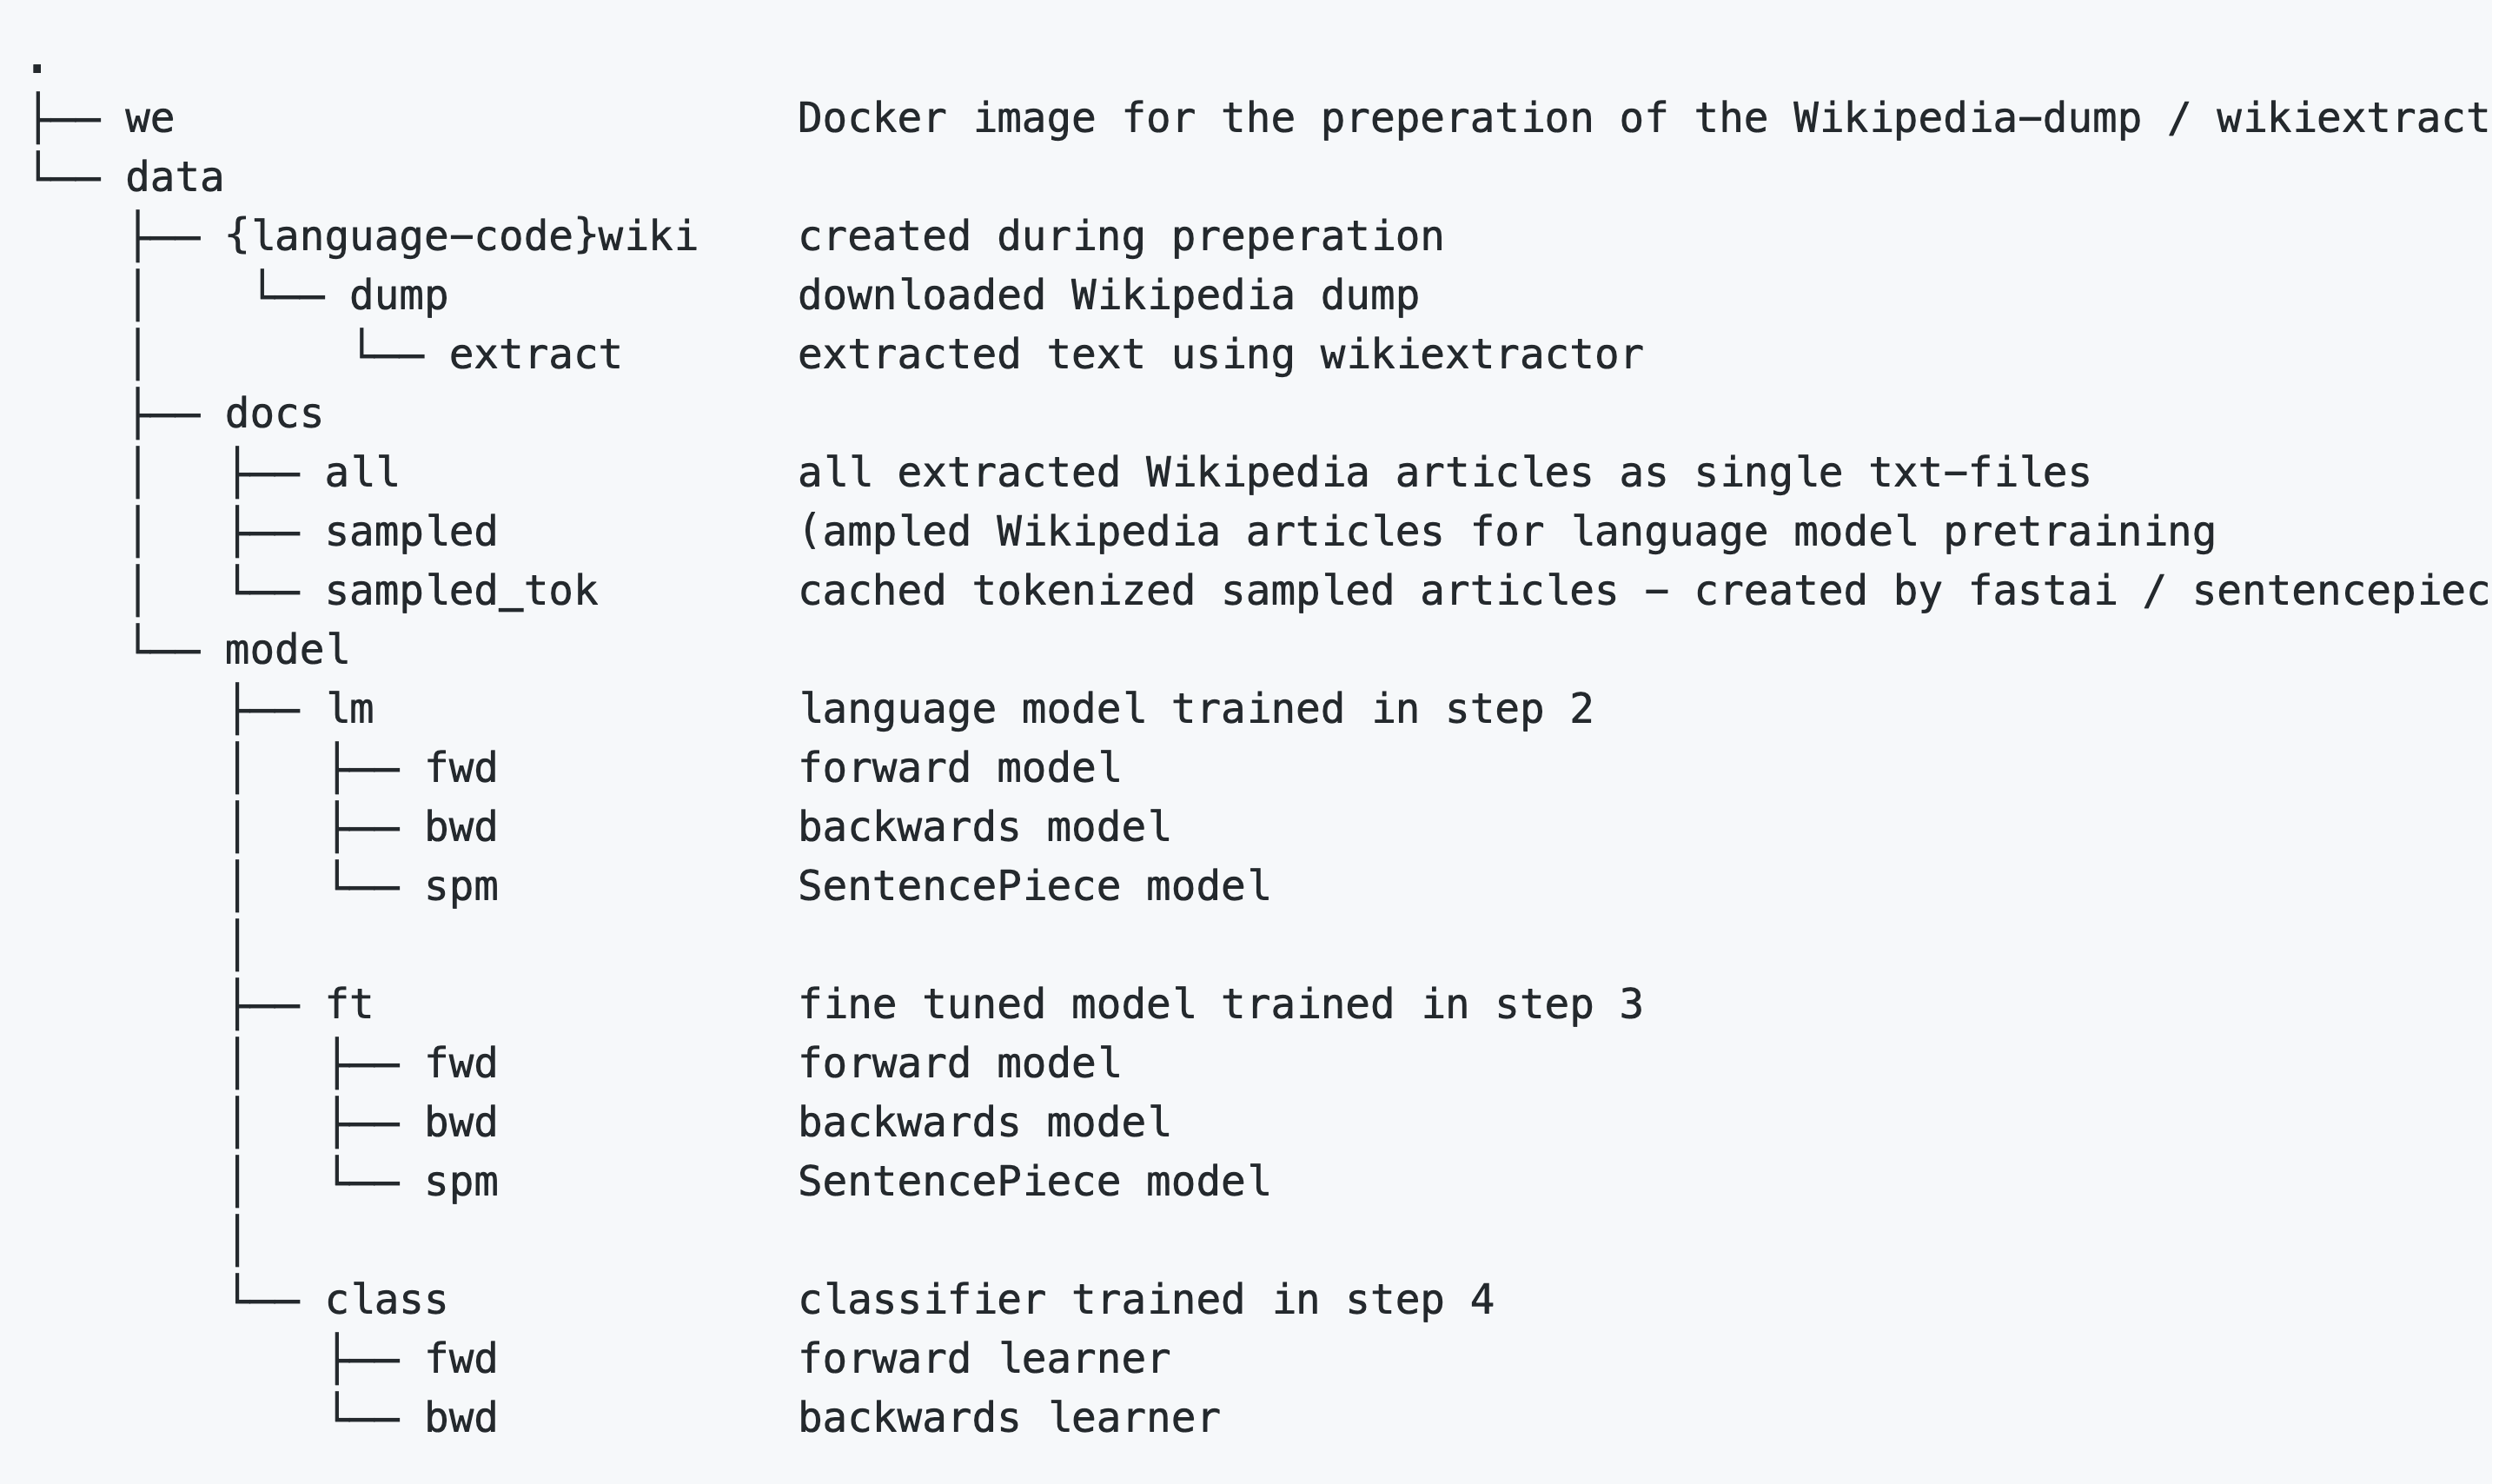

### Download der gesamten Wiki-Textsammlung

In [ ]:
!wget https://wiki-de.s3.eu-de.cloud-object-storage.appdomain.cloud/dewiki.tar.gz

In [ ]:
!ls

In [ ]:
!mkdir data

In [ ]:
# use this line for google colab
#!tar xfz /content/dewiki.tar.gz -C /content/data
# use this one if you run the notebook locally
!tar xfz ./dewiki.tar.gz -C ./data

In [ ]:
!rm dewiki.tar.gz

### Code zum manuellen Download und Extraktion der Wiki-Texte

In [ ]:
import re
import glob
import random
import shutil


def split_wiki(path_extract, path_docs, lang):
    name = f'{lang}wiki'
    dest = path_docs
    source = path_extract/'AA'/'wiki_00'
    if dest.exists():
        print(f"{dest} already exists; not splitting")
        return dest
    else:
        print(f'splitting {source} into {dest}')

    dest.mkdir(exist_ok=True, parents=True)
    title_re = re.compile(rf'<doc id="\d+" url="\?curid=\d+" title="([^"]+)">')
    lines = source.open()
    f=None

    for i,l in enumerate(lines):
        if i%100000 == 0: print(i)
        if l.startswith('<doc id="'):
            title = title_re.findall(l)[0].replace('/','_')
            if len(title)>120: continue
            if f: f.close()
            f = (dest/f'{title}.txt').open('w')
        else: f.write(l)
    f.close()
    return dest


def sample_docs(path_docs, path_lm, min_doc_length, number_docs):
    d = str(f'{path_docs}/*.txt')
    files = glob.glob(d)

    random.shuffle(files)

    i = 0
    n_words = 0
    for fi in files:
        with open(fi, 'r') as f:
            doc = f.readlines()
        
        d = ''.join(doc)
        len_doc = len(d)
        
        if len_doc < min_doc_length: 
            continue
        else:
            shutil.copy(fi, path_lm)
            n_words += len(d.split())
            if i%10000 == 0: print(i)
            i += 1
        
        if i >= number_docs: break
            
    return n_words, i

def cleanup_paths(paths):
    for p in paths:
        print(f'removing {p}')
        try:
            shutil.rmtree(p)
        except Exception as e:
            print(f'Error: {e}')

In [ ]:
lang = 'de'
min_doc_length = 1800
number_docs = 160000
mirror = 'dumps.wikimedia.org'
cleanup = False

name = f'{lang}wiki'
xml_name = f'{name}-latest-pages-articles.xml'
zip_name = f'{xml_name}.bz2'
base_path = Path('/content')
path_data = base_path/(Path('data'))
path_wiki = path_data/name
path_docs = path_data/name/'docs'/'all'
path_dump = path_data/name/'dump'
path_extract = path_dump/'extract'
path_lm = path_data/name/'docs'/'sampled'


# CLEANUP - if --cleanup is set remove directorys and EXIT!
if cleanup:
    paths = [path_docs, path_extract]
    cleanup_paths(paths)
    sys.exit(f'Exiting after clean up!')

if not path_data.exists():
    os.mkdir(path_data)

if not path_wiki.exists():
    os.mkdir(path_wiki)
    os.mkdir(path_wiki/'docs')

if not path_data.exists():
    os.mkdir(path_data)
else:
    print(f'{path_data} already exists')

# DOWNLOAD wikipedia dump

if not (path_dump/xml_name).exists():
    if not path_dump.exists():
        print(f'creating {path_dump}')
        os.mkdir(path_dump)
    # xml does not exist -> download?
    if not (path_dump/zip_name).exists():
        print(f'downloading {zip_name}')
        # zip does not exist -> download!
        os.system(f'wget --no-check-certificate -P {path_dump.absolute()}/ https://{mirror}/{name}/latest/{name}-latest-pages-articles.xml.bz2')

    print(f'unpacking {zip_name}')
    os.system(f'bzip2 -d {path_dump}/{zip_name}')
    
# EXTRACT with wikiextractor

if not path_extract.exists():
    print(f'creating {path_extract}')
    print('running wikiextractor')
    os.system(f'wikiextractor --no-templates -b 100G -q -o /data/{name}/dump/extract/ /data/{name}/dump/{name}-latest-pages-articles.xml')
else:
    print(f'{path_extract} exists - not extracting')


# SPLIT wiki

print('splitting wiki')
if not path_docs.exists():
    print(f'creating {path_docs}')
    split_wiki(path_extract, path_docs, lang)
else:
    print(f'path {path_docs} exists - not splitting')


# SAMPLE n-docs 

n_words = 0
n_docs = 0
print(f'sampling {number_docs} docs')
if not path_lm.exists():
    print(f'creating {path_lm}')
    os.mkdir(path_lm)
    n_words, n_docs = sample_docs(path_docs, path_lm, min_doc_length, number_docs)
else: 
    print(f'{path_lm} exists - skipping sampling documents!')

print(f'sucessfully prepared {name} - {path_lm}, number of docs {n_docs}/{number_docs} with {n_words} words / tokens!')

## Training des Sprachmodells

Wir werden im weiteren zwei Modelle trainieren.

* Eines, das von links nach rechts liest und
* eines, das von rechts nach links liest.

Die beiden Modelle werden in unterschiedlichen Verzeichnissen gespeichert.

_Wichtig für Colab-Nutzer:_ Wir müssen die erstellten Modelle auf einen persistenten Speicher kopieren, damit wir sie auch nach einem Neustart der Colab-Umgebung noch zur Verfügung haben!

In [ ]:
from fastai.text.all import *
from fastai.callback.progress import CSVLogger

In [ ]:
# Wiederholen für Rückwärtsmodell
lang = 'de'
backwards = False
#backwards = True
bs=1280
vocab_sz = 15000
drop_mult = 0.5
num_workers=18
step = 'lm' # language model

In [ ]:
direction = 'fwd' if backwards == False else 'bwd'

In [ ]:
wiki = f'{lang}wiki'
path = Path(f'data/{wiki}')
data_path = path/'docs'/'sampled'
model_path = path/'model'/step/direction
spm_path = path/'model'/step/'spm'
lm_fns = [model_path/f'{lang}_wikitext', model_path/f'{lang}_wikitext_vocab.pkl']

In [ ]:
spm_path.exists()

### Dataloaders erstellen

In [ ]:
if spm_path.exists():
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, sp_model=spm_path/'spm.model')
    print(f'SentencePiece Model exists - using {spm_path}')
else:
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, cache_dir=spm_path)

In [ ]:
dblock = DataBlock(blocks=TextBlock.from_folder(data_path, is_lm=True, tok=tok, backwards=backwards),
                   get_items=get_files,
                   splitter=RandomSplitter(valid_pct=0.1, seed=42),
                  )

dls = dblock.dataloaders(data_path, path=data_path, bs=bs, num_workers=num_workers)

In [ ]:
dls.show_batch()

In [ ]:
len(dls.train), len(dls.valid)

### Trainieren den Modells

In [ ]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=drop_mult, pretrained=False, 
                               metrics=[accuracy, Perplexity()]).to_fp16()
learn.path = model_path.absolute()

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2
num_epochs = 10

In [ ]:
cbs=[CSVLogger(fname=f'history.csv')]

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(num_epochs, lr, cbs=cbs, moms=(0.8, 0.7, 0.8))

### Persistentes Speichern des Modells

In [ ]:
learn.to_fp32().save(lm_fns[0].absolute(), with_opt=False)

In [ ]:
with open(lm_fns[1], 'wb') as f:
      pickle.dump(learn.dls.vocab, f)

In [ ]:
train_params = {
    'lang': lang,
    'step': step,
    'backwards': backwards,
    'batch_size': bs,
    'vocab_size': vocab_sz,
    'lr': lr,
    'num_epochs': num_epochs,
    'drop_mult': drop_mult,
    'stats': {
        'train_loss': stats[0],
        'valid_loss': stats[1],
        'accuracy': stats[2],
        'perplexity': stats[3]
    }
}

with open(f'{model_path}/train_params.json', 'w') as f:
    json.dump(train_params, f, ensure_ascii=False, indent=4)

Modell zB auf gdrive kopieren

## Preprocessing GermEval

In [ ]:
from fastai.text.all import *

In [ ]:
lang = 'de'
num_tweets = 500000
wiki = f'{lang}wiki'
base_path = Path('data')
path = base_path/wiki
data_path = path/'germeval'

In [ ]:
def clean_text(text):
    text = re.sub('@\w+', ' ', text)
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = ' '.join(text.split())
    return text

### Training Data

In [ ]:
names = ['text','label','label_fine']

df_train1 = pd.read_csv(f'{data_path}/germeval2018.test.txt',
                sep ='\t', names=names)
df_train2 = pd.read_csv(f'{data_path}/germeval2018.training.txt',
                sep ='\t', names=names)
df_train3 = pd.read_csv(f'{data_path}/germeval2019.training_subtask1_2_korrigiert.txt',
                sep = '\t', names=names)
df_train4 = pd.read_csv(f'{data_path}/germeval2019.training_subtask3.txt',
                sep = '\t', names=[*names,'label3'])

In [ ]:
df_train4.drop('label3', axis=1, inplace=True)
df_train = pd.concat([df_train1,df_train2,df_train3], sort=False)
df_train['text'] = df_train['text'].apply(clean_text)
df_train['is_valid'] = False

### Test Data GermEval2019

In [ ]:
df_test = pd.read_csv(data_path/'germeval2019/germeval2019GoldLabelsSubtask1_2.txt',
                sep ='\t', names=names)

In [ ]:
df_test['text'] = df_test['text'].apply(clean_text)
df_test['is_valid'] = True
df_class = pd.concat([df_test,df_train], sort=False)
df_class.to_csv(data_path/'data_classification.csv', index=False)
df_class.head()

### Zusätzliche Tweets für das Fintuning

In [ ]:
# Source: https://zenodo.org/record/3633935#.YEVnVi24jzA
import gzip
import json    

with gzip.open(data_path/'detweet/recording-2020-01-21T22-48.json.gz', 'rb') as f:
    data = json.loads(f.read(), encoding="utf-8")
print(data[5000]['id'])
print(data[5000]['text'])

In [ ]:
# Tweet-Texte aus dem Datenset extrahieren
import gzip
import json

json_files = Path(data_path/"detweet/")
lines = 0
files = 0
posts = 0
errors = 0

with (data_path/'tweets.txt').open('a') as tweets:
    for file_path in json_files.glob("*.json.gz"):
        with gzip.open(file_path, 'rb') as f:
            data = json.loads(f.read())
            files += 1
            for tweet in data:
                posts += 1
                try:
                    text = clean_text(tweet['text'])
                    text = text.replace(";","")                    
                    tweets.write(tweet['id'] + ";" + text + "\n")
                    lines += 1
                except:
                    errors += 1
        
print("files: ", files)
print("lines: ", lines)
print("errors: ", errors)
print("tweets: ", posts)

In [ ]:
df_tweet = pd.read_csv(data_path/'tweets.txt', sep=';', header=None, warn_bad_lines=False)
df_tweet.columns = ['id','text']
df_tweet = df_tweet.drop('id', axis=1)

In [ ]:
df_tweet = df_tweet[:num_tweets]
#df_tweet['text'] = df_tweet['text'].apply(clean_text)
len(df_tweet)

In [ ]:
df_lm = pd.concat([df_train, df_tweet], sort=False)
df_lm.drop(['label','label_fine'], axis=1, inplace=True)
df_lm.drop('is_valid', axis=1, inplace=True)

In [ ]:
df_lm.head()

In [ ]:
df_lm.to_csv(data_path/'data_lm.csv', index=False)

## Finetuning

In [ ]:
lang = 'de'
#backwards = False
backwards = True
bs=128
vocab_sz = 15000
num_workers=18
step = 'ft' # fine-tuning

In [ ]:
direction = 'fwd' if backwards == False else 'bwd'

In [ ]:
wiki = f'{lang}wiki'
base_path = Path('data')
path = base_path/wiki
model_base_path = path/'model'
model_path = model_base_path/step/direction
spm_path = model_base_path/step/'spm'
lm_fns = [(model_base_path/'lm'/direction/f'{lang}_wikitext').absolute(), 
          (model_base_path/'lm'/direction/f'{lang}_wikitext_vocab').absolute()]

In [ ]:
data_path = path/'germeval'

In [ ]:
lm_fns, spm_path, direction, backwards

In [ ]:
df = pd.read_csv(data_path/'data_lm.csv')
df.head()

In [ ]:
if spm_path.exists():
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, sp_model=spm_path/'spm.model')
    print(f'SentencePiece Model exists - using {spm_path}')
else:
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, cache_dir=spm_path)

In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, is_lm=True, backwards=backwards)),
                    get_x=ColReader('text'), 
                    splitter=RandomSplitter(valid_pct=0.1, seed=42))
dls = dblocks.dataloaders(df, bs=bs, num_workers=num_workers)

In [ ]:
dls.show_batch()

In [ ]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=True, pretrained_fnames=lm_fns, 
                               metrics=[accuracy, Perplexity()]).to_fp16()
learn.path = model_path

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-1

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/100,lr), moms=(0.8,0.7,0.8))

In [ ]:
lm_ft_fns = [(model_path/f'{lang}_{step}').absolute(), 
             (model_path/f'{lang}_{step}_vocab.pkl').absolute()]

In [ ]:
learn.to_fp32()

In [ ]:
learn.save(lm_ft_fns[0], with_opt=False)

In [ ]:
learn.save_encoder(f'{lm_ft_fns[0]}_encoder')

In [ ]:
with open(lm_ft_fns[1], 'wb') as f:
      pickle.dump(learn.dls.vocab, f)

## Den Klassifizierer trainieren

Germeval 2019 Classification

https://projects.fzai.h-da.de/iggsa/data-2019/


https://www.researchgate.net/publication/337007402_UPB_at_GermEval-2019_Task_2_BERT-Based_Offensive_Language_Classification_of_German_Tweets



In [ ]:
from fastai.text.all import *

In [ ]:
lang = 'de'
#backwards = False
backwards = True
bs=128
vocab_sz = 15000
num_workers=18
step = 'class' # fine-tuning

In [ ]:
direction = 'fwd' if backwards == False else 'bwd'

In [ ]:
wiki = f'{lang}wiki'
base_path = Path('data')
path = base_path/wiki
model_base_path = path/'model'
model_path = model_base_path/step/direction
spm_path = model_base_path/'ft'/'spm'
lm_fns = [(model_base_path/'ft'/direction/f'{lang}_ft').absolute(), 
          (model_base_path/'ft'/direction/f'{lang}_ft_vocab').absolute()]

In [ ]:
data_path = path/'germeval'

In [ ]:
lm_fns, spm_path

In [ ]:
df = pd.read_csv(data_path/'data_classification.csv')
df.head()

In [ ]:
tok = SentencePieceTokenizer(lang=lang, sp_model=spm_path/'spm.model')

In [ ]:
with open(f'{lm_fns[1]}.pkl', 'rb') as f:
      vocab = pickle.load(f)

In [ ]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=vocab, backwards=backwards), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'), 
                    splitter=ColSplitter())
dls = dblocks.dataloaders(df, bs=bs, num_workers=num_workers)

In [ ]:
dls.show_batch()

In [ ]:
dls.vocab[1]

In [ ]:
len(dls.train), len(dls.valid)

In [ ]:
avg = 'macro'
metrics=[accuracy, Precision(average=avg), Recall(average=avg), F1Score(average=avg)]

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=1, pretrained=False, 
                               metrics=metrics).to_fp16()
learn.path = model_path

In [ ]:
learn.load_encoder(f'{lm_fns[0].absolute()}_encoder')

In [ ]:
learn.lr_find()

In [ ]:
lr = 3e-2
lr *= bs/48
lr

In [ ]:
learn.fine_tune(8, lr)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export("lm_de.pkl")

## Einsatz unseres Modells zur Klassifzierung

In [ ]:
lang = 'de'
wiki = f'{lang}wiki'
base_path = Path('data')
path = base_path/wiki
data_path = path/'germeval'
class_path = path/'model'/'class'

In [ ]:
path_fwd = f'{class_path}/fwd/lm_de.pkl'
learn_fwd = load_learner(path_fwd)

In [ ]:
path_bwd = f'{class_path}/bwd/lm_de.pkl'
learn_bwd = load_learner(path_bwd)

In [ ]:
text = 'Komisch das die Realitätsverweigerung immer von linken erbärmlichen Correctiv Accounts ausgeht...'
pred = learn_fwd.predict(text)
pred

### Evaluierung unseres Modells aufgrund von GermEval2019 Datenset

In [ ]:
names = ['text','label','label_fine']

In [ ]:
df_test = pd.read_csv(data_path/'germeval2019GoldLabelsSubtask1_2.txt',
                sep ='\t', names=names)

In [ ]:
def clean_text(text):
    text = re.sub('@\w+', ' ', text)
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = ' '.join(text.split())
    return text
df_test['text'] = df_test['text'].apply(clean_text)

In [ ]:
#forward model
dl_fwd = learn_fwd.dls.test_dl(df_test, with_labels=True)
preds_fwd = learn_fwd.get_preds(dl=dl_fwd)
accuracy(*preds_fwd)

In [ ]:
#backward model
dl_bwd = learn_bwd.dls.test_dl(df_test, with_labels=True)
preds_bwd = learn_bwd.get_preds(dl=dl_bwd)
accuracy(*preds_bwd)

In [ ]:
#ensemble
avg = 'macro'
precision = Precision(average=avg)
recall = Recall(average=avg)
f1score = F1Score(average=avg)

In [ ]:
preds = (preds_fwd[0] + preds_bwd[0]) / 2
a = accuracy(preds, preds_fwd[1])
a

In [ ]:
p = precision(torch.argmax(preds, axis=1), preds_fwd[1])
p

In [ ]:
r = recall(torch.argmax(preds, axis=1), preds_fwd[1])
r

In [ ]:
f1 = f1score(torch.argmax(preds, axis=1), preds_fwd[1])
f1

In [ ]:
stats = {
    'accuracy': float(a),
    'precision': p,
    'recall': r,
    'f1score': f1
}

with open(f'{class_path}/inference_stats.json', 'w') as f:
    json.dump(stats, f, ensure_ascii=False, indent=4)

### Fast Inference

https://muellerzr.github.io/fastinference/

`intrinsic_attention()` zeigt, welche der Tokens besonders relevant / irrelevant für die Klassifizierung waren.

In [ ]:
from fastinference.inference.text import intrinsic_attention
learn_fwd.intrinsic_attention(text)

In [ ]:
learn_fwd.predict(text)